# 堆疊分類(Stacking Classifier)

##### 先引入我們需要的packages

In [1]:
import os 
import numpy as np
import random
from random import choices
import cvxopt
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

# Training Data

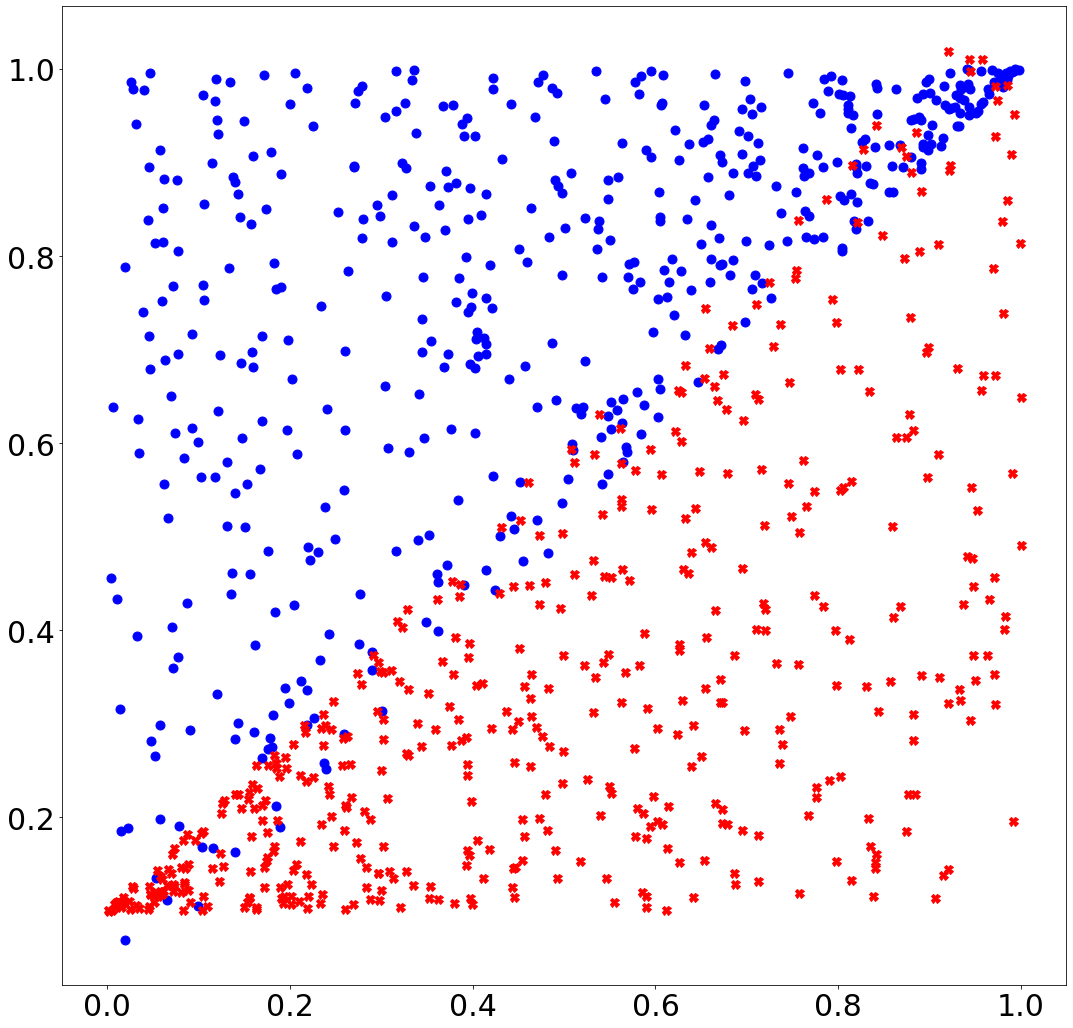

In [2]:
N=1000
x=np.zeros((N,2))
y=np.zeros(N)
for i in range(0,N): 
    f=-0.1
    if(i<N/2):
        y[i]=1
        x[i,0]=random.random()
        x[i,1]=random.uniform(x[i,0],1)
    else:
        y[i]=-1
        x[i,0]=random.random()
        x[i,1]=random.uniform(0,x[i,0])-f
plt.rcParams["figure.figsize"] = (18,18)
plt.plot(x[:500,0],x[:500,1],"bo",markersize=9)
plt.plot(x[500:,0],x[500:,1],"rX",markersize=9)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

# Testing Data

In [3]:
N_test=50
x_test=np.zeros((N_test,2))
y_test=np.zeros(N_test)
for i in range(0,N_test): 
    f=-0.1
    if(i<N_test/2):
        y_test[i]=1
        x_test[i,0]=random.random()
        x_test[i,1]=random.uniform(x_test[i,0],1)
    else:
        y_test[i]=-1
        x_test[i,0]=random.random()
        x_test[i,1]=random.uniform(0,x_test[i,0])-f

# Polynomial Kernel

In [4]:
def Polynomial_kernel(x,xx,power,gamma,zeta):
    return (zeta+gamma*np.dot(x,xx.T))**power

# Perceptron Learning Algorithms

In [5]:
def PLA(x,y,x_test,c,gamma,zeta):
    N=len(y)
    a=np.ones(N)
    K=Polynomial_kernel(x,x,c,gamma,zeta)
    K_test=Polynomial_kernel(x_test,x,c,gamma,zeta)
    b=0
    nn=max((x[:,0]**2)+(x[:,0]**2))
    for i in range(0,1000):
        check=np.sign(np.dot(K,y*a)+b)==y
        i=random.randint(0,N-1)
        if(check[i]==False):
            a[i]+=1
            b+=y[i]*nn
    return np.sign(np.dot(K,a*y)+b),np.sign(np.dot(K_test,a*y)+b)

# Kernel Logistic Regression

In [6]:
def KLR(x,y_temp,x_test,c,gamma,zeta):
    N=len(y_temp)
    BOOL=(y_temp==1)
    y=np.zeros(N)
    y[BOOL]=1
    s=0.002
    lambda_2=0.1
    K=Polynomial_kernel(x,x,c,gamma,zeta)
    K_test=Polynomial_kernel(x_test,x,c,gamma,zeta)
    a=np.zeros(N)
    for i in range(0,500):
        A=(2*lambda_2/N)*np.dot(K,a)
        B=np.dot(K/np.outer(np.ones(N)+np.exp(-np.dot(K,a)),np.ones(N)).T,np.ones(N)-y)/N
        C=np.dot(K/np.outer(np.ones(N)+np.exp(np.dot(K,a)),np.ones(N)).T,-y)/N
        D=(2*lambda_2/N)*np.diagonal(K)
        E=np.dot((K**2)/np.outer(2*np.ones(N)+np.exp(np.dot(K,a))+np.exp(-np.dot(K,a)),np.ones(N)).T,np.ones(N))/N
        a=a-s*(A+B+C)/(D+E)
    return np.sign(np.dot(K,a)),np.sign(np.dot(K_test,a))

# Support Vector Machine

In [7]:
def SVM(x,y,x_test,c,gamma,zeta):
    CC=100
    N=len(y)
    Q = cvxopt.matrix((np.outer(y,y) * Polynomial_kernel(x,x,c,gamma,zeta)))
    p = cvxopt.matrix(np.ones(N)*-1.,(N,1))
    G = cvxopt.matrix(np.concatenate([np.diag(np.ones(N)* 1.),np.diag(np.ones(N)* -1.)])) 
    h = cvxopt.matrix(np.concatenate([CC*np.ones(N),np.zeros(N)]))
    A = cvxopt.matrix(y,(1,N))
    b = cvxopt.matrix(0.0)
    cvxopt.solvers.options['show_progress'] = False
    cvxopt.solvers.options['abstol'] = 1e-10
    cvxopt.solvers.options['reltol'] = 1e-10
    cvxopt.solvers.options['feastol'] = 1e-10
    K=Polynomial_kernel(x,x,c,gamma,zeta)
    K_test=Polynomial_kernel(x_test,x,c,gamma,zeta)
    a=np.array(cvxopt.solvers.qp(Q, p, G, h, A, b)['x']).flatten()
    SV=[]
    for i in range(0,N):
        if(a[i]>1e-6):
            SV.append(i)
    for sv in SV:
        if(y[sv]==1):
            s_u=sv
            break
    Com=0
    for i in range(0,N):
        Com+=y[i]*a[i]*Polynomial_kernel(x[i,:],x[s_u,:],c,gamma,zeta)
    b_u=y[s_u]-Com
    for sv in SV:
        if(y[sv]==-1):
            s_l=sv
            break
    Com=0
    for i in range(0,N):
        Com+=y[i]*a[i]*Polynomial_kernel(x[i,:],x[s_l,:],c,gamma,zeta)
    b_l=y[s_l]-Com
    b=(b_u+b_l)/2
    return np.sign(np.dot(K,a*y)+b),np.sign(np.dot(K_test,a*y)+b)

# Gini Index

In [8]:
def Gini(s,y):
    return 1-((sum(y[s]==1)/len(s))**2+(sum(y[s]==-1)/len(s))**2)

# Computer Error

In [9]:
def Compute_Error(x,y,s_left,s_right,D):
    if(sum(y[s_left]==1)/len(s_left)>sum(y[s_right]==1)/len(s_right)):
        left_class,right_class=1,-1
    elif(sum(y[s_left]==1)/len(s_left)<sum(y[s_right]==1)/len(s_right)):
        left_class,right_class=-1,1
    else:
        if(sum(y[s_left]==-1)/len(s_left)>sum(y[s_right]==-1)/len(s_right)):
            left_class,right_class=-1,1
        else:
            left_class,right_class=-1,-1
    y_check=np.zeros(len(y))
    y_check[s_left],y_check[s_right]=left_class,right_class
    return sum(D*(y!=y_check))/sum(D)

# Decision Stump

In [10]:
def Decision_Stump(x,y,typ,D=None):
    impurity_x0=np.zeros(len(y)-1)
    impurity_x1=np.zeros(len(y)-1)
    x0_sort=np.sort(x[:,0])
    x1_sort=np.sort(x[:,1])
    x0_sort_index=np.argsort(x[:,0])
    x1_sort_index=np.argsort(x[:,1])
    if(typ=="RF"):
        for i in range(1,len(y)):
            s_left,s_right=x0_sort_index[:i],x0_sort_index[i:]
            impurity_x0[i-1]=(len(s_left)/len(y))*Gini(s_left,y)+(len(s_right)/len(y))*Gini(s_right,y)
            s_left,s_right=x1_sort_index[:i],x1_sort_index[i:]
            impurity_x1[i-1]=(len(s_left)/len(y))*Gini(s_left,y)+(len(s_right)/len(y))*Gini(s_right,y)
        if(min(impurity_x0)<min(impurity_x1)):
            x_split=(x0_sort[np.argmin(impurity_x0)]+x0_sort[np.argmin(impurity_x0)+1])/2
            return x_split,0,min(impurity_x0)
        else:
            x_split=(x1_sort[np.argmin(impurity_x1)]+x1_sort[np.argmin(impurity_x1)+1])/2
            return x_split,1,min(impurity_x1)
    elif(typ=="ET"):
        num=300
        seed_feature=np.array(choices(range(0,len(x[0,:])), k=num))
        seed_split=np.zeros(num)
        seed_split[seed_feature==0]=np.random.uniform(min(x[:,0]),max(x[:,0]),sum(seed_feature==0))
        seed_split[seed_feature==1]=np.random.uniform(min(x[:,1]),max(x[:,1]),sum(seed_feature==1))
        impurity=np.zeros(num)
        for i in range(0,num):
            BOOL=x[:,seed_feature[i]]<seed_split[i]
            s_left,s_right=np.array(np.where(BOOL)).flatten(),np.array(np.where(~BOOL)).flatten()
            impurity[i]=(len(s_left)/len(y))*Gini(s_left,y)+(len(s_right)/len(y))*Gini(s_right,y)
        return seed_split[np.argmin(impurity)],seed_feature[np.argmin(impurity)],min(impurity)
    elif(typ=="ABDT"):
        for i in range(1,len(y)):
            s_left,s_right=x0_sort_index[:i],x0_sort_index[i:]
            impurity_x0[i-1]=Compute_Error(x,y,s_left,s_right,D)
            s_left,s_right=x1_sort_index[:i],x1_sort_index[i:]
            impurity_x1[i-1]=Compute_Error(x,y,s_left,s_right,D)
        if(min(impurity_x0)<min(impurity_x1)):
            x_split=(x0_sort[np.argmin(impurity_x0)]+x0_sort[np.argmin(impurity_x0)+1])/2
            return x_split,0,min(impurity_x0)
        else:
            x_split=(x1_sort[np.argmin(impurity_x1)]+x1_sort[np.argmin(impurity_x1)+1])/2
            return x_split,1,min(impurity_x1)
    else:
        print("The type should be RF, ET, and ABDT.")
        return 0,0,0

# Decision Tree Algorithms

In [11]:
def Decision_Tree(x,y,x_real,y_real,x_test,y_test,index,index_test,max_depth,y_train,y_pred,typ,D=None):
    x_split,m,impurity=Decision_Stump(x,y,typ,D)
    p=x[:,m]<x_split
    x_left,y_left=x[p],y[p]
    x_right,y_right=x[~p],y[~p]
    if(D is None):
        D_left,D_right=None,None
    else:
        D_left,D_right=D[p],D[~p]
    p_real=(x_real[:,m]<x_split).flatten()
    p_real_left=np.where(p_real)
    p_real_right=np.where(~p_real)
    left_index=np.intersect1d(p_real_left,index)
    right_index=np.intersect1d(p_real_right,index)
    p_test=(x_test[:,m]<x_split).flatten()
    p_test_left=np.where(p_test)
    p_test_right=np.where(~p_test)
    left_index_test=np.intersect1d(p_test_left,index_test)
    right_index_test=np.intersect1d(p_test_right,index_test)
    check_left=True
    for i in range(0,len(y_left)):
        if(y_left[0]!=y_left[i]):
            check_left=False
            break
    check_right=True
    for i in range(0,len(y_right)):
        if(y_right[0]!=y_right[i]):
            check_right=False
            break
    if((impurity==0)or(max_depth==1)or((check_left)and(check_right))):
        if(sum(y_left==1)/len(y_left)>sum(y_right==1)/len(y_right)):
            label_left,label_right=1,-1
        elif(sum(y_left==1)/len(y_left)<sum(y_right==1)/len(y_right)):
            label_left,label_right=-1,1
        else:
            if(sum(y_left==-1)/len(y_left)>sum(y_right==-1)/len(y_right)):
                label_left,label_right=-1,1
            else:
                label_left,label_right=1,-1
        y_train[left_index],y_train[right_index]=label_left,label_right
        y_pred[left_index_test],y_pred[right_index_test]=label_left,label_right
        return y_train,y_pred
    elif(check_left):
        max_depth-=1
        y_train[left_index]=y_left[0]
        y_pred[left_index_test]=y_left[0]
        y_train,y_pred=Decision_Tree(x_right,y_right,x_real,y_real,x_test,y_test,
                                     right_index,right_index_test,max_depth,y_train,y_pred,typ,D_right)
        return y_train,y_pred
    elif(check_right):
        max_depth-=1
        y_train[right_index]=y_right[0]
        y_pred[right_index_test]=y_right[0]
        y_train,y_pred=Decision_Tree(x_left,y_left,x_real,y_real,x_test,y_test,
                                     left_index,left_index_test,max_depth,y_train,y_pred,typ,D_left)
        return y_train,y_pred
    else:
        max_depth-=1
        y_train,y_pred=Decision_Tree(x_left,y_left,x_real,y_real,x_test,y_test,
                                     left_index,left_index_test,max_depth,y_train,y_pred,typ,D_left)
        y_train,y_pred=Decision_Tree(x_right,y_right,x_real,y_real,x_test,y_test,
                                     right_index,right_index_test,max_depth,y_train,y_pred,typ,D_right)
        return y_train,y_pred

# Random Forest

In [12]:
def Random_Forest(x,y,x_test,y_test,depth,T,typ):
    y_train_RF=np.zeros((len(y),T))
    y_pred_RF=np.zeros((len(y_test),T))
    for i in range(0,T):
        seed=choices(range(0,len(y)), k=len(y))
        y_train_RF[:,i],y_pred_RF[:,i]=Decision_Tree(x[seed,:],y[seed],x,y,x_test,y_test,
                                                     np.where(y),np.where(y_test),depth,
                                                     y_train_RF[:,i],y_pred_RF[:,i],typ)
    return np.sign(np.sum(y_train_RF,axis=1)),np.sign(np.sum(y_pred_RF,axis=1))

# Extra Tree

In [13]:
def Extra_Tree(x,y,x_test,y_test,depth,T,typ):
    y_train_ET=np.zeros((len(y),T))
    y_pred_ET=np.zeros((len(y_test),T))
    for i in range(0,T):
        y_train_ET[:,i],y_pred_ET[:,i]=Decision_Tree(x,y,x,y,x_test,y_test,
                                                     np.where(y),np.where(y_test),depth,
                                                     y_train_ET[:,i],y_pred_ET[:,i],typ)
    return np.sign(np.sum(y_train_ET,axis=1)),np.sign(np.sum(y_pred_ET,axis=1))

# AdaBoosted Decision Tree

In [14]:
def AdaBoosted_Decision_Tree(x,y,x_test,y_test,depth,T,typ):
    y_train=np.zeros((len(y),T))
    y_pred=np.zeros((len(y_test),T))
    D=np.ones(N)/N
    a=np.zeros(T)
    y_train_ABDT=np.zeros(N)
    y_pred_ABDT=np.zeros(N_test)
    for i in range(0,T):
        y_train[:,i],y_pred[:,i]=Decision_Tree(x,y,x,y,x_test,y_test,
                                               np.where(y),np.where(y_test),depth,
                                               y_train[:,i],y_pred[:,i],typ,D)
        error=sum(D*(y_train[:,i]!=y))/sum(D)
        if(error==0):
            T=i-1
            break
        a[i]=0.5*np.log((1-error)/error)
        y_train_ABDT+=a[i]*y_train[:,i]
        y_pred_ABDT+=a[i]*y_pred[:,i]
        D=D*np.exp(-a[i]*y*y_train[:,i])/sum(D)
    return np.sign(y_train_ABDT),np.sign(y_pred_ABDT)

# Training Base Learner

In [15]:
c=5
gamma=1
zeta=1
print("=========================Perceptron Learning Algorithms=========================")
y_train_PLA,y_pred_PLA=PLA(x,y,x_test,c,gamma,zeta)
print("Traing Error",round(1-sum(y_train_PLA==y)/N,3),
      "/ Testing Error",round(1-sum(y_pred_PLA==y_test)/N_test,2))
print("=========================Kernel Logistic Regression=========================")
y_train_KLR,y_pred_KLR=KLR(x,y,x_test,c,gamma,zeta)
print("Traing Error",round(1-sum(y_train_KLR==y)/N,3),
      "/ Testing Error",round(1-sum(y_pred_KLR==y_test)/N_test,2))
print("=========================Support Vector Machine=========================")
y_train_SVM,y_pred_SVM=SVM(x,y,x_test,c,gamma,zeta)
print("Traing Error",round(1-sum(y_train_SVM==y)/N,3),
      "/ Testing Error",round(1-sum(y_pred_SVM==y_test)/N_test,2))
T=12
depth=6
print("=========================Random Forest=========================")
y_train_RF,y_pred_RF=Random_Forest(x,y,x_test,y_test,depth,T,"RF")
print("Traing Error",round(1-sum(y_train_RF==y)/N,3),
      "/ Testing Error",round(1-sum(y_pred_RF==y_test)/N_test,2))
print("=========================Extra Tree=========================")
y_train_ET,y_pred_ET=Extra_Tree(x,y,x_test,y_test,depth,T,"ET")
print("Traing Error",round(1-sum(y_train_ET==y)/N,3),
      "/ Testing Error",round(1-sum(y_pred_ET==y_test)/N_test,2))
print("=========================AdaBoosted Decision Tree=========================")
y_train_ABDT,y_pred_ABDT=AdaBoosted_Decision_Tree(x,y,x_test,y_test,depth,T,"ABDT")
print("Traing Error",round(1-sum(y_train_ABDT==y)/N,3),
      "/ Testing Error",round(1-sum(y_pred_ABDT==y_test)/N_test,2))

=========================Perceptron Learning Algorithms=========================
Traing Error 0.144 / Testing Error 0.16
=========================Kernel Logistic Regression=========================
Traing Error 0.095 / Testing Error 0.1
=========================Support Vector Machine=========================
Traing Error 0.077 / Testing Error 0.12
=========================Random Forest=========================
Traing Error 0.066 / Testing Error 0.2
=========================Extra Tree=========================
Traing Error 0.118 / Testing Error 0.24
=========================AdaBoosted Decision Tree=========================
Traing Error 0.023 / Testing Error 0.2


# Stacking Classifier

In [16]:
NEW_X=np.zeros((N,6))
NEW_X_test=np.zeros((N_test,6))
NEW_X[:,0]=y_train_PLA
NEW_X[:,1]=y_train_KLR
NEW_X[:,2]=y_train_SVM
NEW_X[:,3]=y_train_RF
NEW_X[:,4]=y_train_ET
NEW_X[:,5]=y_train_ABDT
NEW_X_test[:,0]=y_pred_PLA
NEW_X_test[:,1]=y_pred_KLR
NEW_X_test[:,2]=y_pred_SVM
NEW_X_test[:,3]=y_pred_RF
NEW_X_test[:,4]=y_pred_ET
NEW_X_test[:,5]=y_pred_ABDT
y_train_Final,y_pred_Final=SVM(NEW_X,y,NEW_X_test,c,gamma,zeta)
print("=========================Stacking Classifier=========================")
print("Traing Error",round(1-sum(y_train_Final==y)/N,3),
      "/ Testing Error",round(1-sum(y_pred_Final==y_test)/N_test,2))

=========================Stacking Classifier=========================
Traing Error 0.016 / Testing Error 0.2
